#  MODIS Water Cluster Training

Version: 0.1.0

Date modified: 05.01.2023

Modified by: Amanda Burke

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path   
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline


import optuna
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold
#from sklearn.inspection import permutation_importance


# #GDAL Stuff
# from osgeo import gdalconst
# from osgeo import gdal
# from pprint import pprint

# GPU-based frameworks

# import cudf
# import cupy as cp
# from cuml.ensemble import RandomForestClassifier as cuRFC

In [2]:
GPU = False
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
FRAC_LAND=0.5
num_datapoints = 10000000

In [3]:
# #############################
# # VERSION 4.2.1 (targeted 500k points)
# TILE_IN = 'Golden'#v4.2.1
# DATA_VERSION='v4.2.1'
# offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']
# #############################

##############################
#VERSION 2.0.1 (5 million points)
TILE_IN = 'GLOBAL'#v2.0.1
DATA_VERSION='v2.0.1'
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day']
##############################

# #############################
# #VERSION 0.0.0 (2billion data points)
# TILE_IN = 'cleaned'#v2.0.1
# DATA_VERSION='AGU'
# offsets_indexes = []#'x_offset', 'y_offset', 'year', 'julian_day']
# ##############################

training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
data_paths = sorted([fv for fv in glob.glob(glob_string)])

#Only want the one with 4.2.0 because the other file doesnt work. 
print(data_paths)
data_path = data_paths[0]
print(data_path)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.1/MOD09_GLOBAL_5469777_2_0_1.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v2.0.1/MOD09_GLOBAL_5469777_2_0_1.parquet.gzip


In [4]:
def load_cpu_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
            dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
            applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
            multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]

    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        if land:
            print('Imbalancing data, sampling {} from water'.format(frac))
        else:
            print(f'Imbalancing data, sampling {frac} from land, {1-frac} from water')
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

In [5]:
colsToDrop = [
            #'sur_refl_b01_1',
            # 'sur_refl_b02_1',
             'sur_refl_b03_1',
             'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
            # 'sur_refl_b07_1',
             # 'ndvi',
             'ndwi1','ndwi2'
            ]

colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

### Input data

In [6]:
colsToDrop

['sur_refl_b03_1',
 'sur_refl_b04_1',
 'sur_refl_b05_1',
 'sur_refl_b06_1',
 'ndwi1',
 'ndwi2']

In [7]:
%%time
X, X_test, y, y_test = load_cpu_data(fpath=data_path,
                                             colsToDrop=colsToDropTraining,
                                             dataType=DATA_TYPE,
                                             splitXY=True,
                                             imbalance=False,
                                             trainTestSplit=True)
X = X.iloc[:num_datapoints,:] 
y = y.iloc[:num_datapoints] 

X_test = X_test.iloc[:num_datapoints,:] 
y_test = y_test.iloc[:num_datapoints] 

print(f'data shape: {X.shape}, {y.shape}')

data shape: (4375821, 4), (4375821,)
CPU times: user 3.71 s, sys: 940 ms, total: 4.65 s
Wall time: 4.66 s


In [8]:
#Getting the indices that are associated with land (0) and water (1)
y_water_ind = np.where(y>0.5)[0]
y_land_ind = np.where(y<0.5)[0]

#Subset the X AND y data to later/ subset with the clusters and then combine for RFA
X_water = X.iloc[y_water_ind,:]
y_water = y.iloc[y_water_ind]

X_land = X.iloc[y_land_ind,:]
y_land = y.iloc[y_land_ind]

In [9]:
_ = [print(column) for column in X.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b07_1
ndvi


### Comparing targeted and clustered samples


In [10]:
# DATA_VERSION='v4.2.1'
# training_data_basepath = f'/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/{DATA_VERSION}'

# #VERSION 4.2.1
# TILE_IN = 'Golden'#v4.2.1
# offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day','tileID']

# glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE_IN))
# data_paths = sorted([fv for fv in glob.glob(glob_string)])

# #Only want the one with 4.2.0 because the other file doesnt work. 
# print(data_paths)
# data_path = data_paths[0]
# print(data_path)
# colsToDropTraining = colsToDrop.copy()
# colsToDropTraining.extend(offsets_indexes)


# X_target, X_test_target, y_target, y_test_target = load_data(fpath=data_path,
#                                 colsToDrop=colsToDropTraining,
#                                 dataType=DATA_TYPE,
#                                 cpu=True,
#                                 splitXY=True,
#                                 trainTestSplit=True
#                                 )

# X_target = X_target.iloc[:num_datapoints,:] 
# y_target = y_target.iloc[:num_datapoints] 

# X_test_target = X_test_target.iloc[:num_datapoints,:] 
# y_test_target = y_test_target.iloc[:num_datapoints] 

# print(f'\n\ntarget subset data shape: {X_target.shape}, {y_target.shape}')

# #Getting the indices that are associated with land (0) and water (1)
# #Subset the X AND y data to later subset with the clusters and then combine for RFA
# X_water_target = X_target.iloc[np.where(y_target>0.5)[0],:]
# X_land_target = X_target.iloc[np.where(y_target<0.5)[0],:]

### Clustering Data for Input to Random Forest

Based on the cluster analysis above on 5.03.23, 15 clusters appears to have the most data and exclude outliers so will use that number for selection 

In [11]:
CLUSTER_NUM=15

common_params = {
    "n_init": "auto",
    "random_state": 42,
    "init":"random"
}

In [12]:
%%time
kme_land_random =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land_random = kme_land_random.predict(X_land)

CPU times: user 7min 21s, sys: 27 s, total: 7min 48s
Wall time: 12.6 s


In [13]:
%%time
kme_water_random = KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water_random = kme_water_random.predict(X_water)

CPU times: user 2min 49s, sys: 10.9 s, total: 3min
Wall time: 4.73 s


### Even Balanced Random pulled datapoints

In [36]:
COUNT_EVEN_BALANCE_LAND = np.inf
COUNT_EVEN_BALANCE_WATER = np.inf
for cluster in np.unique(kmeans_output_water_random):
    land_num = len(np.where(kmeans_output_land_random == cluster)[0])
    water_num = len(np.where(kmeans_output_water_random == cluster)[0])
    if land_num < COUNT_EVEN_BALANCE_LAND: COUNT_EVEN_BALANCE_LAND = land_num
    if water_num < COUNT_EVEN_BALANCE_WATER: COUNT_EVEN_BALANCE_WATER = water_num
    
print(COUNT_EVEN_BALANCE_LAND, COUNT_EVEN_BALANCE_WATER)
if COUNT_EVEN_BALANCE_LAND < COUNT_EVEN_BALANCE_WATER:
    COUNT = COUNT_EVEN_BALANCE_LAND
else: 
    COUNT = COUNT_EVEN_BALANCE_WATER
print(COUNT,COUNT_EVEN_BALANCE_LAND,COUNT_EVEN_BALANCE_WATER)

890 8658
890 890 8658


In [37]:
# np.random.seed(42)
random_ind_land = np.array([])
random_ind_water = []

for cluster in np.unique(kmeans_output_water_random):
    print(f'cluster {cluster}')
    cluster_ind_water = np.where(kmeans_output_water_random == cluster)[0]
    random_pts_water = np.random.choice(cluster_ind_water,COUNT,replace=False)
    max_X_random_water = np.nanmax(X_water['sur_refl_b01_1'].iloc[random_pts_water])
    if max_X_random_water < 10000:
        random_ind_water = np.append(random_ind_water, random_pts_water)
    else: print(f'Cluster {cluster} contains outliers')
    
    cluster_ind_land = np.where(kmeans_output_land_random == cluster)[0]
    random_pts_land = np.random.choice(cluster_ind_land,COUNT,replace=False)
    random_ind_land = np.append(random_ind_land, random_pts_land)
    
random_ind_water = random_ind_water.astype('int')
random_ind_land = random_ind_land.astype('int')

print(random_ind_water,random_ind_land)

cluster 0
cluster 1
cluster 2
cluster 3
cluster 4
Cluster 4 contains outliers
cluster 5
cluster 6
cluster 7
cluster 8
cluster 9
cluster 10
cluster 11
cluster 12
cluster 13
cluster 14
[ 417433 1267323    5294 ...  370575 1368124  919577] [1630785  825048  735648 ... 1074337  873594 2299887]


In [ ]:
# X_cluster_land_random = X_land.iloc[random_ind_land]
# y_cluster_land_random = y_land.iloc[random_ind_land]
# X_cluster_water_random = X_water.iloc[random_ind_water]
# y_cluster_water_random = y_water.iloc[random_ind_water]

# X_cluster_random = pd.concat([X_cluster_land_random,X_cluster_water_random])
# y_cluster_random = pd.concat([y_cluster_land_random,y_cluster_water_random])

# #Combine the data so that we can shuffle the indices and keep the data together that should be
# All_data_random = pd.concat([X_cluster_random,y_cluster_random],axis=1).sample(frac=1)

# X_cluster_rfa_random = All_data_random[X_cluster_random.columns]
# y_cluster_rfa_random = All_data_random['water']

In [ ]:
# # print(All_data_random)
# print(X_match_rfa_random)
# print(y_match_rfa_random)

### Percentage Random pulled datapoints

In [14]:
# List of the clusters: kmeans_output_land and kmeans_output_water
# Data: X_water, X_land, y_water, y_land

PERCENT_RANDOM_PULL = 0.15

In [15]:



# np.random.seed(42)
random_ind_land = np.array([])
random_ind_water = []

for cluster in np.unique(kmeans_output_water_random):
    print(f'cluster {cluster}')
    cluster_ind_water = np.where(kmeans_output_water_random == cluster)[0]
    # cluster_ind_water = np.where(bgm_water == cluster)[0]
    COUNT_RANDOM_PULL_WATER = int(PERCENT_RANDOM_PULL*len(cluster_ind_water))
    random_pts_water = np.random.choice(cluster_ind_water,COUNT_RANDOM_PULL_WATER,replace=False)
    max_X_random_water = np.nanmax(X_water['sur_refl_b01_1'].iloc[random_pts_water])
    if max_X_random_water < 10000:
        random_ind_water = np.append(random_ind_water, random_pts_water)
    else: print(f'Cluster {cluster} contains outliers')
    
    cluster_ind_land = np.where(kmeans_output_land_random == cluster)[0]
    # cluster_ind_land = np.where(bgm_land == cluster)[0]
    COUNT_RANDOM_PULL_LAND = int(PERCENT_RANDOM_PULL*len(cluster_ind_land))
    random_pts_land = np.random.choice(cluster_ind_land,COUNT_RANDOM_PULL_LAND,replace=False)
    random_ind_land = np.append(random_ind_land, random_pts_land)
    print(f'Pulling {COUNT_RANDOM_PULL_WATER} Water pts and {COUNT_RANDOM_PULL_LAND} Land pts')
    print()
random_ind_water = random_ind_water.astype('int')
random_ind_land = random_ind_land.astype('int')

print(random_ind_water,random_ind_land)

cluster 0
Pulling 33394 Water pts and 133 Land pts

cluster 1
Pulling 51258 Water pts and 39150 Land pts

cluster 2
Pulling 25355 Water pts and 41383 Land pts

cluster 3
Pulling 14297 Water pts and 34975 Land pts

cluster 4
Cluster 4 contains outliers
Pulling 1298 Water pts and 42733 Land pts

cluster 5
Pulling 5589 Water pts and 13240 Land pts

cluster 6
Pulling 5118 Water pts and 19572 Land pts

cluster 7
Pulling 25931 Water pts and 22311 Land pts

cluster 8
Pulling 13605 Water pts and 26401 Land pts

cluster 9
Pulling 6770 Water pts and 13114 Land pts

cluster 10
Pulling 31086 Water pts and 1255 Land pts

cluster 11
Pulling 5271 Water pts and 42318 Land pts

cluster 12
Pulling 38228 Water pts and 168 Land pts

cluster 13
Pulling 31333 Water pts and 36052 Land pts

cluster 14
Pulling 8146 Water pts and 26874 Land pts

[1231836 1702554 1667640 ... 1385527 1688664 1378216] [1208581  287687 1316137 ... 2369828 1628155 1028369]


In [ ]:
fig, ax = plt.subplots(2, 2,figsize=(20, 10))
var=0
for col in range(2):
    ax[col, 0].set_ylabel('Frequency') 
    for row in range(2):
        variable=X_cpu.columns[var]
        if 'ndvi' in variable: 
            continue
            var_bins = bin_boundaries
            log_values = False
        else: 
            var_bins = None
            log_values = True
        ax[row, col].hist(
            [   
            X_cpu[variable][not_same_point.index].values
            ],
            label=[
            "data"
            ],
            bins=var_bins,
        color=['brown'], log=log_values) 
        ax[row, col].set_xlabel(f'{variable}')
        var+=1
    ax[0,0].legend(loc='upper right',fontsize=20)
plt.show()

### Total random dataset used for training random forest

In [38]:
match_ind_land = np.random.choice(
    np.arange(len(X_land)),len(random_ind_land),replace=False)
print(random_ind_land)
print(match_ind_land)

match_ind_water = np.random.choice(
    np.arange(len(X_water)),len(random_ind_water),replace=False)
print(len(random_ind_water))
print(len(match_ind_water))

# X_match_land_random = X_land.iloc[match_ind_land]
# y_match_land_random = y_land.iloc[match_ind_land]
# X_match_water_random = X_water.iloc[match_ind_water]
# y_match_water_random = y_water.iloc[match_ind_water]

X_match_land_random = X_land.iloc[random_ind_land]
y_match_land_random = y_land.iloc[random_ind_land]
X_match_water_random = X_water.iloc[random_ind_water]
y_match_water_random = y_water.iloc[random_ind_water]

X_match_random = pd.concat([X_match_land_random,X_match_water_random])
y_match_random = pd.concat([y_match_land_random,y_match_water_random])

#Combine the data so that we can shuffle the indices and keep the data together that should be
All_data_match_random = pd.concat([X_match_random,y_match_random],axis=1).sample(frac=1).reset_index(drop=True)

X_match_rfa_random = All_data_match_random[X_match_random.columns]
y_match_rfa_random = All_data_match_random['water']

[1630785  825048  735648 ... 1074337  873594 2299887]
[155355 953635 796815 ... 130768 160128   9565]
12460
12460


In [39]:
# print(All_data_random)
print(X_match_rfa_random)
print(y_match_rfa_random)

       sur_refl_b01_1  sur_refl_b02_1  sur_refl_b07_1   ndvi
0                  -9               1              23 -12500
1                 726            1009             872   1631
2                  36              -3              23 -11818
3                 229             388               2   2576
4                 748            2736             815   5706
...               ...             ...             ...    ...
25805              60              -6              56 -12222
25806              33             -18              27  31536
25807             128            -100              -4 -15892
25808             -94             -14              47  -7407
25809             -12              -3              52  -6000

[25810 rows x 4 columns]
0        1
1        0
2        1
3        1
4        0
        ..
25805    1
25806    1
25807    0
25808    1
25809    1
Name: water, Length: 25810, dtype: int16


In [ ]:
# X_cluster_land_random = X_land.iloc[random_ind_land]
# y_cluster_land_random = y_land.iloc[random_ind_land]
# X_cluster_water_random = X_water.iloc[random_ind_water]
# y_cluster_water_random = y_water.iloc[random_ind_water]

# X_cluster_random = pd.concat([X_cluster_land_random,X_cluster_water_random])
# y_cluster_random = pd.concat([y_cluster_land_random,y_cluster_water_random])

# #Combine the data so that we can shuffle the indices and keep the data together that should be
# All_data_random = pd.concat([X_cluster_random,y_cluster_random],axis=1).sample(frac=1)

# X_cluster_rfa_random = All_data_random[X_cluster_random.columns]
# y_cluster_rfa_random = All_data_random['water']

### Plotting paramater space

In [49]:
%%time

kme_land_random =  KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_land)
kmeans_output_land_random = kme_land_random.predict(X_land)
kme_water_random = KMeans(n_clusters=CLUSTER_NUM, **common_params).fit(X_water)
kmeans_output_water_random = kme_water_random.predict(X_water)

CPU times: user 15min 33s, sys: 1min 10s, total: 16min 44s
Wall time: 28.5 s


In [50]:
%%time

np.random.seed(42)
random_ind_land_eb = np.array([])
random_ind_water_eb = []

for cluster in np.unique(kmeans_output_water_random):
    print(f'cluster {cluster}')
    cluster_ind_water = np.where(kmeans_output_water_random == cluster)[0]
    random_pts_water = np.random.choice(cluster_ind_water,COUNT,replace=False)
    max_X_random_water = np.nanmax(X_water['sur_refl_b01_1'].iloc[random_pts_water])
    if max_X_random_water < 10000:
        random_ind_water_eb = np.append(random_ind_water_eb, random_pts_water)
    else: print(f'Cluster {cluster} contains outliers')
    
    cluster_ind_land = np.where(kmeans_output_land_random == cluster)[0]
    random_pts_land = np.random.choice(cluster_ind_land,COUNT,replace=False)
    random_ind_land_eb = np.append(random_ind_land_eb, random_pts_land)
    
random_ind_water_eb = random_ind_water_eb.astype('int')
random_ind_land_eb = random_ind_land_eb.astype('int')

print(random_ind_water_eb,random_ind_land_eb)


#############

match_ind_land_eb = np.random.choice(np.arange(len(X_land)),len(random_ind_land_eb),replace=False)
match_ind_water_eb = np.random.choice(np.arange(len(X_water)),len(random_ind_water_eb),replace=False)

X_match_land_eb = X_land.iloc[match_ind_land_eb]
X_match_water_eb = X_water.iloc[match_ind_water_eb]
X_match_eb = pd.concat([X_match_land_eb,X_match_water_eb])

X_cluster_land_eb = X_land.iloc[random_ind_land_eb]
X_cluster_water_eb = X_water.iloc[random_ind_water_eb]
X_cluster_eb = pd.concat([X_cluster_land_eb,X_cluster_water_eb])




cluster 0
cluster 1
cluster 2
cluster 3
cluster 4
Cluster 4 contains outliers
cluster 5
cluster 6
cluster 7
cluster 8
cluster 9
cluster 10
cluster 11
cluster 12
cluster 13
cluster 14
[ 881353  233325  245712 ...   26559  213111 1581653] [2056862  877151 1291211 ...  175528 2391374  433047]
CPU times: user 302 ms, sys: 2.24 ms, total: 304 ms
Wall time: 302 ms


In [51]:
%%time


#############
np.random.seed(42)
random_ind_land_p = np.array([])
random_ind_water_p= []

for cluster in np.unique(kmeans_output_water_random):
    print(f'cluster {cluster}')
    cluster_ind_water = np.where(kmeans_output_water_random == cluster)[0]
    # cluster_ind_water = np.where(bgm_water == cluster)[0]
    COUNT_RANDOM_PULL_WATER = int(PERCENT_RANDOM_PULL*len(cluster_ind_water))
    random_pts_water = np.random.choice(cluster_ind_water,COUNT_RANDOM_PULL_WATER,replace=False)
    max_X_random_water = np.nanmax(X_water['sur_refl_b01_1'].iloc[random_pts_water])
    if max_X_random_water < 10000:
        random_ind_water_p = np.append(random_ind_water_p, random_pts_water)
    else: print(f'Cluster {cluster} contains outliers')
    
    cluster_ind_land = np.where(kmeans_output_land_random == cluster)[0]
    # cluster_ind_land = np.where(bgm_land == cluster)[0]
    COUNT_RANDOM_PULL_LAND = int(PERCENT_RANDOM_PULL*len(cluster_ind_land))
    random_pts_land = np.random.choice(cluster_ind_land,COUNT_RANDOM_PULL_LAND,replace=False)
    random_ind_land_p = np.append(random_ind_land_p, random_pts_land)
    print(f'Pulling {COUNT_RANDOM_PULL_WATER} Water pts and {COUNT_RANDOM_PULL_LAND} Land pts')
    print()
random_ind_water_p = random_ind_water_p.astype('int')
random_ind_land_p = random_ind_land_p.astype('int')

print(random_ind_water_p,random_ind_land_p)

#############

match_ind_land_p = np.random.choice(np.arange(len(X_land)),len(random_ind_land_p),replace=False)
match_ind_water_p = np.random.choice(np.arange(len(X_water)),len(random_ind_water_p),replace=False)

X_match_land_p = X_land.iloc[match_ind_land_p]
X_match_water_p = X_water.iloc[match_ind_water_p]
X_match_p = pd.concat([X_match_land_p,X_match_water_p])

X_cluster_land_p = X_land.iloc[random_ind_land_p]
X_cluster_water_p = X_water.iloc[random_ind_water_p]
X_cluster_p = pd.concat([X_cluster_land_p,X_cluster_water_p])

cluster 0
Pulling 33394 Water pts and 133 Land pts

cluster 1
Pulling 51258 Water pts and 39150 Land pts

cluster 2
Pulling 25355 Water pts and 41383 Land pts

cluster 3
Pulling 14297 Water pts and 34975 Land pts

cluster 4
Cluster 4 contains outliers
Pulling 1298 Water pts and 42733 Land pts

cluster 5
Pulling 5589 Water pts and 13240 Land pts

cluster 6
Pulling 5118 Water pts and 19572 Land pts

cluster 7
Pulling 25931 Water pts and 22311 Land pts

cluster 8
Pulling 13605 Water pts and 26401 Land pts

cluster 9
Pulling 6770 Water pts and 13114 Land pts

cluster 10
Pulling 31086 Water pts and 1255 Land pts

cluster 11
Pulling 5271 Water pts and 42318 Land pts

cluster 12
Pulling 38228 Water pts and 168 Land pts

cluster 13
Pulling 31333 Water pts and 36052 Land pts

cluster 14
Pulling 8146 Water pts and 26874 Land pts

[ 881353  233325  245712 ... 1605821  587097 1863434] [2056862  877151 1291211 ...  458067 1743782  881244]
CPU times: user 393 ms, sys: 2 ms, total: 395 ms
Wall time: 

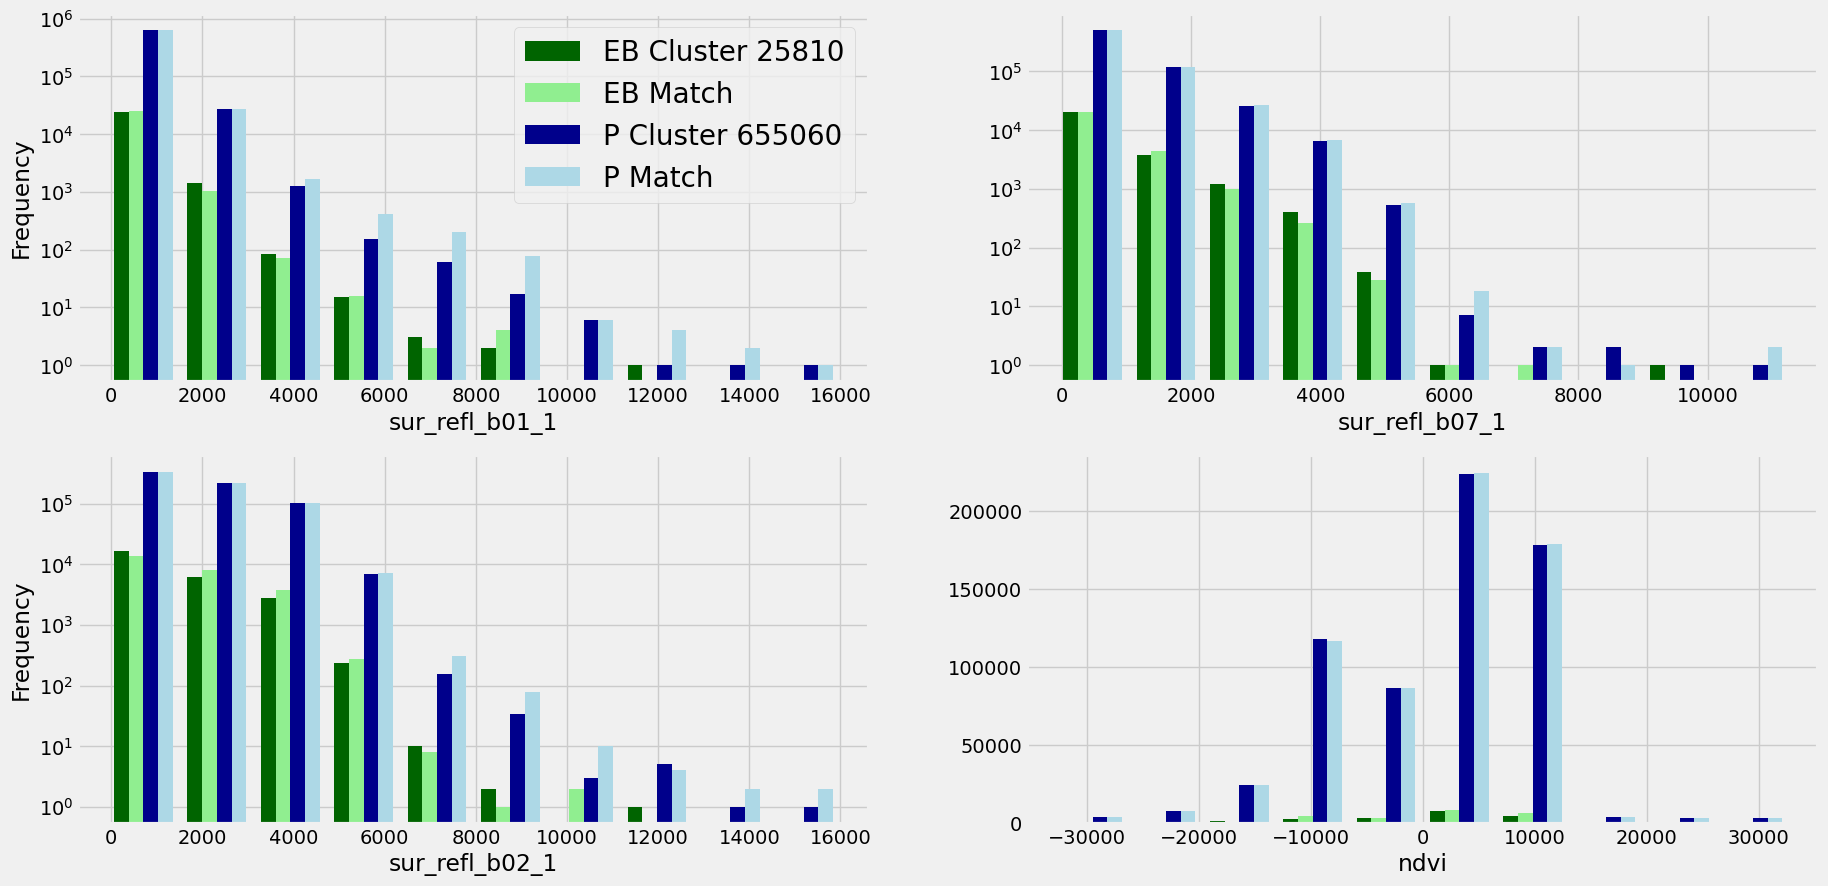

In [57]:
fig, ax = plt.subplots(2, 2,figsize=(20, 10))
var=0
for col in range(2):
    ax[col, 0].set_ylabel('Frequency') 
    for row in range(2):
        variable=X_land.columns[var]
        if 'ndvi' in variable: 
            # var_bins = bin_boundaries
            log_values = False
        else: 
            # var_bins = None
            log_values = True
        ax[row, col].hist(
            [  
            X_cluster_eb[variable].values,
            X_match_eb[variable].values,
            X_cluster_p[variable].values,
            X_match_p[variable].values,
            ],
            label=[
            f"EB Cluster {len(X_cluster_eb)}",
            "EB Match",
            f"P Cluster {len(X_match_p)}",
            f"P Match"
            ],
            #bins=var_bins,
        color=['darkgreen','lightgreen','darkblue','lightblue'], log=log_values) 
        ax[row, col].set_xlabel(f'{variable}')
        var+=1
    ax[0,0].legend(loc='upper right',fontsize=20)
plt.show()

## Random forest

In [ ]:
# FIGURE_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
# RASTER_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
# MODEL_OUTPUT_DIR = ''#/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

# qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
# waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

# test_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'

# ##Add in the other stuff for tuning
# frac_water = int(100*(1.0-FRAC_LAND))
# if len(colsToDrop) >= 1:
#     save_file = f"{TILE}_{DAY}_{YEAR}_frac-water{frac_water}_no-vars_{'-'.join(colsToDrop)}"
# else: 
#      save_file = f"{TILE}_{DAY}_{YEAR}_frac-water{frac_water}_all-vars"

# print(save_file)

#### RF FUNCTIONS

In [40]:
def cpu_rf_objective(trial):
    list_trees = [75, 100, 125, 150, 175, 200, 250, 300, 400, 500]
    max_depth = [5, 10, 30, 50, 80, 90, 100, 110]
    min_samples_leaf = [1, 2, 3, 4, 5]
    min_samples_split = [2, 4, 8, 10]
    bootstrap = [True, False]
    max_features = ['auto', 'sqrt', 'log2']
    
    # if TREES_AND_DEPTH_ONLY:
    #     param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
    #                'criterion':'gini', 
    #                'max_depth':trial.suggest_categorical('max_depth', max_depth), 
    #                'min_samples_split':2, 
    #                'min_samples_leaf':1, 
    #                'min_weight_fraction_leaf':0.0, 
    #                'max_features':'auto', 
    #                'max_leaf_nodes':None, 
    #                'min_impurity_decrease':0.0, 
    #                'bootstrap':True, 
    #                'oob_score':False, 
    #                'n_jobs':-1, 
    #                # 'random_state':42, 
    #                'verbose':0, 
    #                'warm_start':True, 
    #                'class_weight':None, 
    #                'ccp_alpha':0.0, 
    #                'max_samples':None
    #                   }
    # else:
    param = {'n_estimators': trial.suggest_categorical('n_estimators', list_trees), 
                       'max_depth':trial.suggest_categorical('max_depth', max_depth), 
                       'min_samples_split':trial.suggest_categorical('min_samples_split', min_samples_split), 
                       'min_samples_leaf':trial.suggest_categorical('min_samples_leaf', min_samples_leaf), 
                       'bootstrap': trial.suggest_categorical('bootstrap', bootstrap),
                       'criterion':'gini', 
                       #'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 1e-8, 1.0, log=True), 
                       'max_features':trial.suggest_categorical('max_features', max_features), 
                       'max_leaf_nodes':None, 
                       'min_impurity_decrease':0.0, 
                       'oob_score':False, 
                       'n_jobs':-1, 
                       # 'random_state':42, 
                       'verbose':0, 
                       'warm_start':False, 
                       'class_weight':None, 
                       'ccp_alpha':0.0, 
                       'max_samples':None
                      }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    #######################
    # HERE IS WHERE TO CHANGE THE X,Y DATASET USED FOR TRAINING
    #######################
   
    cv_scores = np.empty(5)
    # for idx, (train_idx, val_idx) in enumerate(cv.split(X,y)):
    #     # X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    #     # y_train, y_val = y.iloc[train_idx],  y.iloc[val_idx]

#     for idx, (train_idx, val_idx) in enumerate(cv.split(X_cluster_rfa_random,  y_cluster_rfa_random)):    
#         X_train, X_val = X_cluster_rfa_random.iloc[train_idx], X_cluster_rfa_random.iloc[val_idx]
#         y_train, y_val = y_cluster_rfa_random.iloc[train_idx],  y_cluster_rfa_random.iloc[val_idx]
    # for idx, (train_idx, val_idx) in enumerate(cv.split(X_cluster_rfa_center, y_cluster_rfa_center)):
    #     X_train, X_val = X_cluster_rfa_center.iloc[train_idx], X_cluster_rfa_center.iloc[val_idx]
    #     y_train, y_val = y_cluster_rfa_center.iloc[train_idx], y_cluster_rfa_center.iloc[val_idx]

    for idx, (train_idx, val_idx) in enumerate(cv.split(X_match_rfa_random,  y_match_rfa_random)):    
        X_train, X_val = X_match_rfa_random.iloc[train_idx], X_match_rfa_random.iloc[val_idx]
        y_train, y_val = y_match_rfa_random.iloc[train_idx],  y_match_rfa_random.iloc[val_idx]     
   
        model = skRF(**param)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        cv_scores[idx] = f1_score(y_val, preds)
        if cv_scores[idx] == 0.0:
            print('Pruning because of 0.0 score.')
            return 0.0
        print('Fold {}: {}'.format(idx, cv_scores[idx]))
    return np.mean(cv_scores)

search_space={
    "n_estimators": [75, 100, 125, 150, 175, 200, 250, 300, 400, 500],
    "max_depth" : [5,10, 30, 50, 80, 90, 100, 110],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "min_samples_split" : [2, 4, 8, 10],
    "bootstrap" : [True, False],
    "max_features" : ['auto', 'sqrt', 'log2'],
    
}
TREES_AND_DEPTH_ONLY = False
GRID_SEARCH = True

#### Training RF

In [41]:
%%time

optuna.logging.set_verbosity(optuna.logging.INFO)
if GRID_SEARCH:
    study = optuna.create_study(study_name='RF Tuning Grid Search', 
                                direction='maximize',
                                sampler=optuna.samplers.GridSampler(search_space))
    
else:
    study = optuna.create_study(study_name='RF Tuning',
                                direction='maximize')
#Objective is under the functions area

#####################################################################
#CHANGE HERE FOR DIFFERENT MODELING TYPE
#rf_objective or xgb_objective
#####################################################################

study.optimize(cpu_rf_objective, n_trials=25, timeout=30*600)

[I 2023-10-24 17:21:20,333] A new study created in memory with name: RF Tuning Grid Search


Fold 0: 0.9076527585525015
Fold 1: 0.9014641867827463
Fold 2: 0.9003368337626313
Fold 3: 0.905675301562191


[I 2023-10-24 17:21:27,360] Trial 0 finished with value: 0.9034657218664994 and parameters: {'n_estimators': 500, 'max_depth': 80, 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 0 with value: 0.9034657218664994.


Fold 4: 0.9021995286724274
Fold 0: 0.9087024087024087
Fold 1: 0.906092355452076
Fold 2: 0.905667701863354
Fold 3: 0.9093731806714536


[I 2023-10-24 17:21:34,004] Trial 1 finished with value: 0.9059014034534586 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9059014034534586.


Fold 4: 0.8996713705780012
Fold 0: 0.9094152626362735
Fold 1: 0.9019996040388041
Fold 2: 0.9014866204162538
Fold 3: 0.9061514195583595


[I 2023-10-24 17:21:35,647] Trial 2 finished with value: 0.9042782567082049 and parameters: {'n_estimators': 100, 'max_depth': 80, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9059014034534586.


Fold 4: 0.9023383768913343
Fold 0: 0.9106967615309127
Fold 1: 0.9083398898505115
Fold 2: 0.9075927015891702
Fold 3: 0.909553641346907


[I 2023-10-24 17:21:38,178] Trial 3 finished with value: 0.9079923448705124 and parameters: {'n_estimators': 175, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.9037787300350603
Fold 0: 0.9073966220151427
Fold 1: 0.9044561198676785
Fold 2: 0.9045401629802096
Fold 3: 0.9088445906715696


[I 2023-10-24 17:21:42,224] Trial 4 finished with value: 0.9049469965943573 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.8994974874371858
Fold 0: 0.9025702331141663
Fold 1: 0.8971405877680698
Fold 2: 0.8978859194256084
Fold 3: 0.9004758128469468


[I 2023-10-24 17:21:49,393] Trial 5 finished with value: 0.8984017908995737 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.8939364013430773
Fold 0: 0.9109105180533752
Fold 1: 0.9051266941661756
Fold 2: 0.9068762278978388
Fold 3: 0.9095546399843045


[I 2023-10-24 17:21:51,346] Trial 6 finished with value: 0.9072867730965442 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.9039657853810265
Fold 0: 0.9124678917210038
Fold 1: 0.9056454796683774
Fold 2: 0.9040663245163838
Fold 3: 0.9079440173467377


[I 2023-10-24 17:21:57,756] Trial 7 finished with value: 0.906922957986841 and parameters: {'n_estimators': 400, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.9044910766817023
Fold 0: 0.9105336242808967
Fold 1: 0.9044233807266983
Fold 2: 0.9033663366336634
Fold 3: 0.9091627172195893


[I 2023-10-24 17:22:05,719] Trial 8 finished with value: 0.906142373062492 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.9032258064516129
Fold 0: 0.9093787099327265
Fold 1: 0.904055390702275
Fold 2: 0.9018599129402454
Fold 3: 0.9085534095388254


[I 2023-10-24 17:22:06,955] Trial 9 finished with value: 0.9053157609049917 and parameters: {'n_estimators': 75, 'max_depth': 110, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.9027313814108862
Fold 0: 0.9073246551389159
Fold 1: 0.9051975861397703
Fold 2: 0.9054919464389675
Fold 3: 0.9089497185012618


[I 2023-10-24 17:22:08,797] Trial 10 finished with value: 0.9052461197231347 and parameters: {'n_estimators': 125, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.8992666923967579
Fold 0: 0.9067236688690244
Fold 1: 0.9042801556420234
Fold 2: 0.9057703516611619
Fold 3: 0.9093023255813953


[I 2023-10-24 17:22:10,483] Trial 11 finished with value: 0.9049836401190609 and parameters: {'n_estimators': 125, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.8988416988416988
Fold 0: 0.909952606635071
Fold 1: 0.9045922406967537
Fold 2: 0.9040933359699427
Fold 3: 0.9086965095641885


[I 2023-10-24 17:22:11,727] Trial 12 finished with value: 0.9064006380631874 and parameters: {'n_estimators': 75, 'max_depth': 80, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.9046684974499803
Fold 0: 0.9071428571428571
Fold 1: 0.9016263387544625
Fold 2: 0.8999205718824465
Fold 3: 0.9045544554455446


[I 2023-10-24 17:22:14,303] Trial 13 finished with value: 0.9026645802862895 and parameters: {'n_estimators': 175, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.900078678206137
Fold 0: 0.8985623003194889
Fold 1: 0.8928785158587672
Fold 2: 0.8968681428286455
Fold 3: 0.8974307906791474


[I 2023-10-24 17:22:16,299] Trial 14 finished with value: 0.8954019181911781 and parameters: {'n_estimators': 125, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.8912698412698412
Fold 0: 0.9066348827969805
Fold 1: 0.8992278756681844
Fold 2: 0.8993448481238833
Fold 3: 0.9006727344677482


[I 2023-10-24 17:22:17,498] Trial 15 finished with value: 0.9009672834959762 and parameters: {'n_estimators': 75, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.8989560764230845
Fold 0: 0.9114624505928853
Fold 1: 0.9059288537549407
Fold 2: 0.9069767441860465
Fold 3: 0.9092341012010239


[I 2023-10-24 17:22:21,631] Trial 16 finished with value: 0.90766907753616 and parameters: {'n_estimators': 250, 'max_depth': 80, 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.9047432379459035
Fold 0: 0.9126482213438736
Fold 1: 0.9043856183326748
Fold 2: 0.904375371213621
Fold 3: 0.9100570753788624


[I 2023-10-24 17:22:23,252] Trial 17 finished with value: 0.9074120011203421 and parameters: {'n_estimators': 100, 'max_depth': 110, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 3 with value: 0.9079923448705124.


Fold 4: 0.9055937193326792
Fold 0: 0.9120125416421713
Fold 1: 0.9074474356455099
Fold 2: 0.9078792630341043
Fold 3: 0.91090659878598


[I 2023-10-24 17:22:30,550] Trial 18 finished with value: 0.9087518368260339 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 18 with value: 0.9087518368260339.


Fold 4: 0.9055133450224041
Fold 0: 0.9124387855044074
Fold 1: 0.907840440165062
Fold 2: 0.90623774029031
Fold 3: 0.9114766940853899


[I 2023-10-24 17:22:34,214] Trial 19 finished with value: 0.9085103019350175 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 18 with value: 0.9087518368260339.


Fold 4: 0.9045578496299181
Fold 0: 0.9122324759473788
Fold 1: 0.9065200314218381
Fold 2: 0.9059929494712105
Fold 3: 0.91090659878598


[I 2023-10-24 17:22:36,967] Trial 20 finished with value: 0.9083743183196663 and parameters: {'n_estimators': 175, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'log2'}. Best is trial 18 with value: 0.9087518368260339.


Fold 4: 0.9062195359719244
Fold 0: 0.911337779521381
Fold 1: 0.9080550098231827
Fold 2: 0.9066666666666666
Fold 3: 0.9112286890064668


[I 2023-10-24 17:22:38,852] Trial 21 finished with value: 0.9086235482860507 and parameters: {'n_estimators': 125, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.9087518368260339.


Fold 4: 0.9058295964125561
Fold 0: 0.9070083478936128
Fold 1: 0.9045675413022352
Fold 2: 0.9043275761692218
Fold 3: 0.9096886482305163


[I 2023-10-24 17:22:43,771] Trial 22 finished with value: 0.9051029667685764 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 18 with value: 0.9087518368260339.


Fold 4: 0.8999227202472952
Fold 0: 0.9038155802861685
Fold 1: 0.9014866204162538
Fold 2: 0.8997020854021848
Fold 3: 0.9025742574257426


[I 2023-10-24 17:22:45,339] Trial 23 finished with value: 0.9009020186982021 and parameters: {'n_estimators': 100, 'max_depth': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features': 'log2'}. Best is trial 18 with value: 0.9087518368260339.


Fold 4: 0.8969315499606609
Fold 0: 0.9100633914421553
Fold 1: 0.9021932424422052
Fold 2: 0.9015421115065243
Fold 3: 0.9075862068965517


[I 2023-10-24 17:22:47,721] Trial 24 finished with value: 0.9048816233589398 and parameters: {'n_estimators': 150, 'max_depth': 90, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.9087518368260339.


Fold 4: 0.9030231645072634
CPU times: user 15min 34s, sys: 23.1 s, total: 15min 57s
Wall time: 1min 27s


In [42]:
trials = study.best_trials            
max_trial_score = max([trial.values[0] for trial in trials])
max_trial_params = [trial.params for trial in trials 
                        if trial.values[0] == max_trial_score][0]
max_trial_params['n_jobs'] = -1
score_print = int(np.round(max_trial_score,4)*1000)
print(score_print)

908


In [ ]:
# print(len(X_cluster_land_random),len(X_cluster_water_random),trial_score )

In [43]:
hyperparameters = max_trial_params
hyperparameters['n_jobs'] = -1
print('Using these params:')
print(hyperparameters)
tuned_classifier = skRF(**hyperparameters)

Using these params:
{'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 'log2', 'n_jobs': -1}


In [44]:
%%time 
tuned_classifier.fit(X_match_rfa_random , y_match_rfa_random)

CPU times: user 14.7 s, sys: 412 ms, total: 15.1 s
Wall time: 1.37 s


RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=3,
                       min_samples_split=10, n_estimators=500, n_jobs=-1)

In [45]:
import pickle
# save the model to disk
filename = f'rfa_models/MODIS_RFA_v201_EBcluster_MaxScore{score_print}_sfcref127ndvi_old.pkl'
print(filename)
pickle.dump(tuned_classifier, open(filename, 'wb'))

rfa_models/MODIS_RFA_v201_EBcluster_MaxScore908_sfcref127ndvi_old.pkl


In [ ]:
pickled_model = pickle.load(open('rfa_models/MODIS_RFA_v201_EBCluster_sfcref127ndvi_4.pkl', 'rb'))
print(pickled_model)

In [ ]:
# EB1: 0.9121361508267432
# EB2: 0.9152120215067565
# EB3: 0.9153888116216589
# EB4: 0.9334065797136774
# EB5: 0.9330483639924072
# EB6: 0.9325007563612594
# EB7: 13875 12950 0.9330562509477165
# EB8: 14220 13272 0.9119937102685194 
# EB9: 13875 12950 0.9318627771973583
# EB10: 14220 13272 0.9128319097402475

# %1: 359648 295422 0.9778067788170863
# %2: 359649 295421 0.977828848863204
# %3: 359649 295421 0.977814397217147
# %4: 359648 295421 0.9777926266177195
# %5: 359650 295422 0.9778923365411023
# %6: 359843 295233 0.9779668774041262
# %7: 359841 295230 0.977761799842581
# %8: 359840 296518 0.977231470922011
# %9: 359835 295223 0.977650365098458
# %10: 359837 295222 0.9778535497660246
